In [3]:
using Plots, StatsBase,  Flux 
include("./MapLattice.jl");

In [36]:
lattice_size = 500
N_steps = 500
st_field = map_lattice(rand(lattice_size), N_steps-1, circle_map; coupling=1.0, nonlinearity=1.0 )
T, X = size(st_field)

(500, 500)

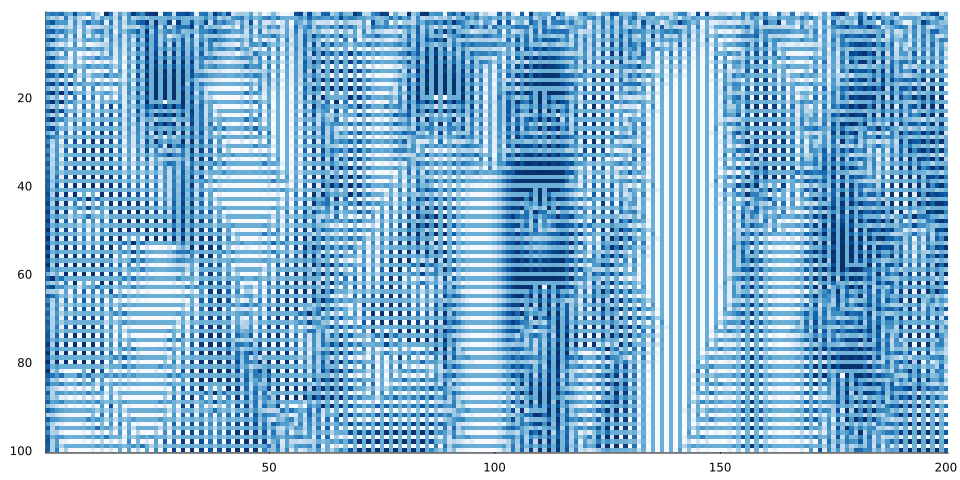

In [37]:
diagram(st_field[1:100, 1:200]; color=:Blues, scale=480)

### functions for generating training data

In [5]:
function circle_map_cae_data(N_ensemble, space, time; 
                                  transient=300, coupling=1.0, nonlinearity=1.0)
    ensemble = Array{Float32}(undef, space, 1,1, time*N_ensemble)
    for n in 1:N_ensemble
        initial = rand(space)
        field = map_lattice(initial, transient+time, circle_map; coupling=coupling, nonlinearity=nonlinearity)
        train_field = convert(Array{Float32}, field)[transient+2:end, :]
        T, X = size(train_field)
        for t in 1:T
            ens_offset = (n-1)*T
            ensemble[:,:,:, ens_offset+t] = reshape(train_field[t, :], (space,1,1))
        end
    end
    return ensemble
end

function circle_map_MAEF_data(N_ensemble, space, time; 
                              transient=300, coupling=1.0, nonlinearity=1.0)
    inputs = Array{Float32}(undef, space, 1,1, time*N_ensemble)
    outputs = Array{Float32}(undef, space, 1,1, time*N_ensemble)
    for n in 1:N_ensemble
        initial = rand(space)
        field = map_lattice(initial, transient+time, circle_map; coupling=coupling, nonlinearity=nonlinearity)
        train_field = convert(Array{Float32}, field)[transient+1:end, :]
        for t = 1:time
            ens_offset = (n-1)*time
            inputs[:,:,:, ens_offset+t] = reshape(train_field[t, :], (space,1,1))
            outputs[:,:,:, ens_offset+t] = reshape(train_field[t+1, :], (space,1,1))
        end
    end
    return inputs, outputs
end

circle_map_MAEF_data (generic function with 1 method)

In [86]:
Xtrain, Ytrain = circle_map_MAEF_data(50, 500, 500)
size(Xtrain)

(500, 1, 1, 25000)

In [87]:
Xtest, Ytest = circle_map_MAEF_data(5, 500, 500)
size(Xtest)

(500, 1, 1, 2500)

### define the convolutional autoencoder

(note that some of the layer sizes depend on the size of the spatial lattice of the input data)

In [4]:
struct Reshape
    shape
end
Reshape(args...) = Reshape(args)
(r::Reshape)(x) = reshape(x, r.shape)
Flux.@functor Reshape ()

In [144]:
test = Flux.Chain(
    Flux.Conv((5,1), 1=>12, Flux.elu),
    Flux.MeanPool((2,1)),
    Flux.Conv((5,1), 12=>32, Flux.elu),
    Flux.MeanPool((2,1)),
    Flux.flatten,
)
size(test(Xtest))

(3904, 2500)

In [147]:
N_latent = 100
encoder = Flux.Chain(
    Flux.Conv((5,1), 1=>12, Flux.elu),
    Flux.MeanPool((2,1)),
    Flux.Conv((5,1), 12=>32, Flux.elu),
    Flux.MeanPool((2,1)),
    Flux.flatten,
    Flux.Dense(3904, N_latent, Flux.elu)
    );

In [148]:
decoder = Flux.Chain(
    Flux.Dense(N_latent, 3904, Flux.elu),
    Reshape(122, 1, 32, :),
    Flux.Upsample(scale=(2,1)),
    Flux.ConvTranspose((5,1), 32=>12, Flux.elu),
    Flux.Upsample(scale=(2,1)),
    Flux.ConvTranspose((5,1), 12=>1, Flux.elu)
    );

In [149]:
size(decoder(encoder(Xtrain)))

(500, 1, 1, 25000)

In [134]:
size(Xtrain)

(500, 1, 1, 25000)

### first, train the autoencoder only

In [151]:
autoencoder = Chain(encoder, decoder)

Chain(
  Chain(
    Conv((5, 1), 1 => 12, elu),         # 72 parameters
    MeanPool((2, 1)),
    Conv((5, 1), 12 => 32, elu),        # 1_952 parameters
    MeanPool((2, 1)),
    Flux.flatten,
    Dense(3904 => 100, elu),            # 390_500 parameters
  ),
  Chain(
    Dense(100 => 3904, elu),            # 394_304 parameters
    Reshape((122, 1, 32, Colon())),
    Upsample(:nearest, scale = (2, 1)),
    ConvTranspose((5, 1), 32 => 12, elu),  # 1_932 parameters
    Upsample(:nearest, scale = (2, 1)),
    ConvTranspose((5, 1), 12 => 1, elu),  # 61 parameters
  ),
)                   # Total: 12 arrays, 788_821 parameters, 3.010 MiB.

In [106]:
size(autoencoder(Xtest))

(500, 1, 1, 2500)

In [152]:
ae_loss(ae, x) = Flux.mse(ae(x), x) 

ae_loss (generic function with 1 method)

In [153]:
ae_dataset = Flux.DataLoader(Xtrain, batchsize=100)

250-element DataLoader(::Array{Float32, 4}, batchsize=100)
  with first element:
  500×1×1×100 Array{Float32, 4}

initial visual evaluation

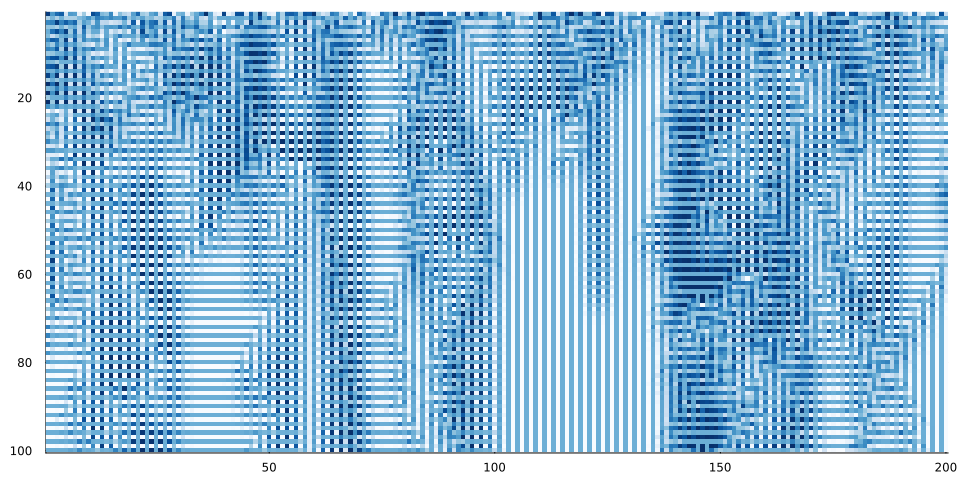

In [101]:
sample_field = map_lattice(rand(500), 99, circle_map; coupling=1.0, nonlinearity=1.0 )
diagram(sample_field[:, 1:200]; color=:Blues, scale=480)

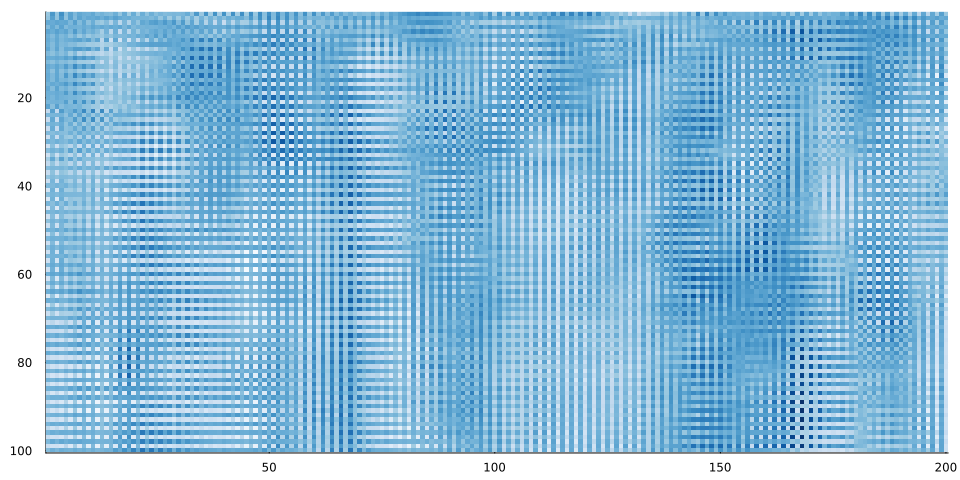

In [163]:
eval_field = Array{Float32}(undef, size(sample_field))
for t in axes(sample_field, 1)
    eval_field[t, :] = autoencoder(reshape(sample_field[t, :], (500, 1,1,1)))
end
diagram(eval_field[:, 1:200]; color=:Blues, scale=480)

In [154]:
opt_state = Flux.setup(OptimiserChain(WeightDecay(10^(-5)), Adam(0.001)), autoencoder)
train_losses = []
test_losses = [];

In [161]:
@time for epoch in 1:100
    for data in ae_dataset
        x = data
        grads = Flux.gradient(autoencoder) do m
            ae_loss(m, x)
            # x̂ = m(x)
            # Flux.mse(x, x̂)
        end
        Flux.update!(opt_state, autoencoder, grads[1])
    end
    train_loss = ae_loss(autoencoder, Xtrain)
    push!(train_losses, train_loss)
    test_loss = ae_loss(autoencoder, Xtest)
    push!(test_losses, test_loss)
end

1618.208222 seconds (34.67 M allocations: 2.104 TiB, 7.41% gc time, 0.04% compilation time)


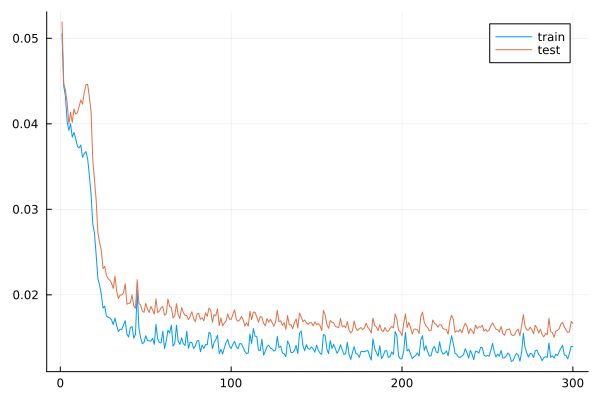

In [162]:
Plots.plot(train_losses; label="train")
Plots.plot!(test_losses; label="test")

In [167]:
markov_loss(m, x,y) = Flux.mse(m(x), y)

markov_loss (generic function with 1 method)

In [150]:
Φ = Dense(N_latent => N_latent; bias=false)

Dense(100 => 100; bias=false)  # 10_000 parameters

In [165]:
markovAE = Chain(encoder, Φ, decoder)

Chain(
  Chain(
    Conv((5, 1), 1 => 12, elu),         # 72 parameters
    MeanPool((2, 1)),
    Conv((5, 1), 12 => 32, elu),        # 1_952 parameters
    MeanPool((2, 1)),
    Flux.flatten,
    Dense(3904 => 100, elu),            # 390_500 parameters
  ),
  Dense(100 => 100; bias=false),        # 10_000 parameters
  Chain(
    Dense(100 => 3904, elu),            # 394_304 parameters
    Reshape((122, 1, 32, Colon())),
    Upsample(:nearest, scale = (2, 1)),
    ConvTranspose((5, 1), 32 => 12, elu),  # 1_932 parameters
    Upsample(:nearest, scale = (2, 1)),
    ConvTranspose((5, 1), 12 => 1, elu),  # 61 parameters
  ),
)                   # Total: 13 arrays, 798_821 parameters, 3.048 MiB.

In [171]:
dataset = Flux.DataLoader((Xtrain, Ytrain), batchsize=100)

250-element DataLoader(::Tuple{Array{Float32, 4}, Array{Float32, 4}}, batchsize=100)
  with first element:
  (500×1×1×100 Array{Float32, 4}, 500×1×1×100 Array{Float32, 4},)

In [166]:
opt_state = Flux.setup(OptimiserChain(WeightDecay(10^(-5)), Adam(0.001)), markovAE)
train_losses = []
test_losses = [];

In [180]:
@time for epoch in 1:100
    for data in dataset
        x,y = data
        grads = Flux.gradient(markovAE) do m
            markov_loss(m, x,y)
            # x̂ = m(x)
            # Flux.mse(x, x̂)
        end
        Flux.update!(opt_state, markovAE, grads[1])
    end
    train_loss = markov_loss(markovAE, Xtrain,Ytrain)
    push!(train_losses, train_loss)
    test_loss = markov_loss(markovAE, Xtest,Ytest)
    push!(test_losses, test_loss)
end

1571.653399 seconds (36.56 M allocations: 2.109 TiB, 6.25% gc time, 0.04% compilation time)


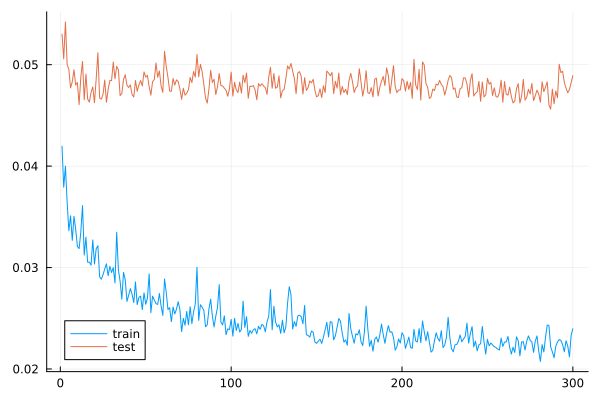

In [181]:
Plots.plot(train_losses; label="train")
Plots.plot!(test_losses; label="test")

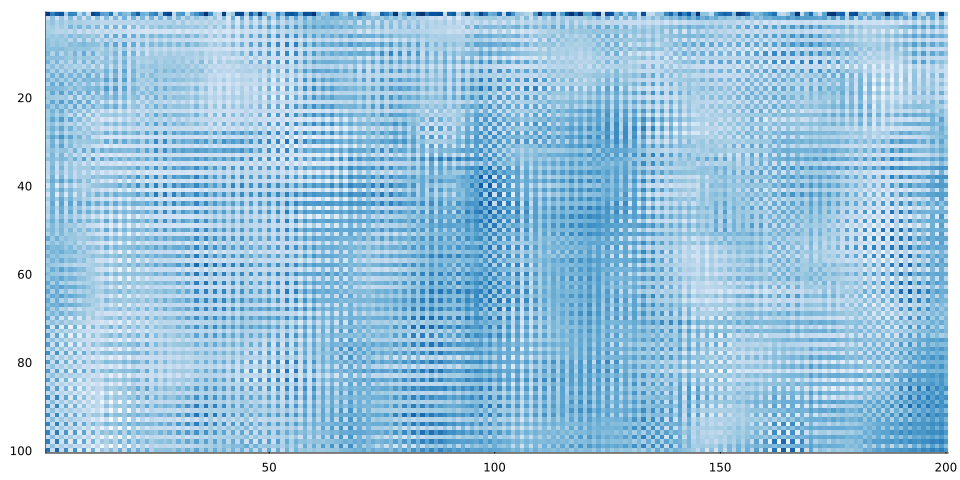

In [182]:
T, X = size(sample_field)
eval_field = Array{Float32}(undef, (T, X))
eval_field[1, :] = sample_field[1, :]
for t in 1:(T-1)
    eval_field[t+1, :] = markovAE(reshape(sample_field[t, :], (500, 1,1,1)))
end
diagram(eval_field[:, 1:200]; color=:Blues, scale=480)